In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
camvid_path = kagglehub.dataset_download('carlolepelaars/camvid')

print('Data source import complete.')

Using Colab cache for faster access to the 'camvid' dataset.
Data source import complete.



# **Programming Assignment 1 - Semantic Segmentation**

#### **Professor**: Dário Oliveira  
#### **Monitor**: Lívia Meinhardt

Neste trabalho prático, vocês irão investigar o desempenho de modelos de segmentação semântica, utilizando redes U-Net e DeepLabV3. A proposta vai além de treinar modelos: vocês deverão analisar onde eles funcionam bem (ou não), interpretar os erros e justificar suas decisões com base nos conceitos vistos em aula.


### **Instruções:**

1. **Escolha do Ambiente de Execução**:  
   Utilize Google Colab ou Kaggle Notebook. Recomendamos iniciar seu notebook no Kaggle diretamente da página do dataset [CamVid](https://www.kaggle.com/datasets/carlolepelaars/camvid).

3. **Criação de um Dataset Customizado**:  
   As máscaras vêm em formato RGB. Use o CSV fornecido para converter as cores em labels (classe por pixel). Crie seu próprio Dataset em PyTorch.

4. **Construção da Arquitetura U-Net**:  
   Implemente uma U-Net (ou ResUNet), com a possibilidade de variar sua profundidade (número de blocos codificadores/decodificadores). Explore como isso impacta o desempenho e a quantidade de parâmetros.

   ![Estrutura U-Net](https://camo.githubusercontent.com/6b548ee09b97874014d72903c891360beb0989e74b4585249436421558faa89d/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67)

5. **Função de Treinamento**:  
   Crie uma função de treinamento e registre métricas (loss, acurácia) em cada época. A cada 5 ou 10 épocas, visualize uma predição (imagem original, máscara verdadeira e predita).

6. **Experimentação**:
    Além da profundidade da rede e como ela afeta desempenho e quantidade de parâmetros, explore pelo menos dois otimizadores e funções de perda adequadas para segmentação semântica. Fundamente as escolhas e explique os resultados de acordo com a teoria vista em aula.

8. **Avaliação**:
   Implemente as métricas por classe: Precisão e IoU. Além da média geral, use para identificar as classes com pior desempenho e caracterizar seu melhor modelo.

9. **Explicabilidade com Mapas de Erro**:
   Escolha imagens com desempenho ruim (menor IoU ou precisão) e gere mapas de erro. Analise visualmente onde o modelo erra (bordas, classes confundidas, objetos pequenos, etc.). Relacione os erros às métricas.

10. **Data Augmentation**:  
     Implemente alguma forma de data augmentation. Avalie se houve ganho em desempenho. Justifique.

11. **Fine-Tuning do DeepLabV3**:
   Realize o fine-tuning do modelo [DeepLabV3](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_resnet50.html#torchvision.models.segmentation.deeplabv3_resnet50) pré-treinado ajustando `classifier` e `aux_classifier` para o número de classes do seu dataset. Congele o backbone conforme necessário e treine o modelo. Compare seu desempenho com a melhor U-Net em termos de métricas, número de parâmetros e qualidade visual das predições.

12. **Apresentação Final**:  
    Ao final, prepare uma apresentação resumindo os passos seguidos, resultados obtidos, gráficos de perdas e acurácia, e discussões sobre o desempenho do modelo. Lembre de fundamentar a discussão com os aspectos teoricos vistos em sala de aula.


### **Pontos Importantes:**

- Escolher adequadamente o tamanho do BATCH, Loss Function e Otimizador e saber o motivo de cada escolha;
- Monitore o uso das GPUs, o kaggle te informa quantidade de tempo disponível, mas o colab não;
- Observe as classes com mais erros por parte do modelo;
- Adicione gráficos de perda e acurácia na sua apresentação;
- Coloque imagens das predições do modelo;
- Use **Pytorch !!!**.

Note que as instruções acima são os requisitos da entrega, mas não precisam ser feitas exatamente nesta ordem. Você pode implementar o lógica de validação do modelo, testar uma versão inicial e modificar conforme os resultados obtidos. Lembre-se de fundamentas suas escolhas e fluxo de trabalho na apresentação.

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision.transforms import ToTensor, Lambda
from torchvision.io import decode_image
import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
import glob

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
f"using device {device}"

'using device cuda'

In [3]:
#----------------------------I/O no Kaggle------------------------------
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
#------------------Dataset para carregar as imagens---------------------
class CamVidDataset(Dataset):

    #inicializa o dataset
    def __init__(self, type_, img_dim = [720, 960], dataset_path = ("/", "kaggle", "input", "camvid"), device = "cpu"):
        #Carrega o caminho do conjunto desejado (val, train, test)
        self.base_path_data = os.path.join(*dataset_path, "CamVid", f"{type_}")
        self.base_path_labels = os.path.join(*dataset_path, "CamVid", f"{type_}_labels")
        self.data = glob.glob(os.path.join(self.base_path_data, "*.png"))

        #Carrega o csv com as classes e trata ele
        df = pd.read_csv(os.path.join(*dataset_path, "CamVid", "class_dict.csv"))
        df = df.reset_index().rename(columns = {"index": "class"})
        self.df = df.set_index(["r", "g", "b"])

        #Faz uma array de lookup pra converter o rgb pra classe mais eficientemente
        self.lookup_classes = np.zeros((256, 256, 256), dtype = "uint8")
        for (r, g, b), row in self.df.iterrows():
            self.lookup_classes[r, g, b] = row["class"]

        self.device = device

        self.resize_img = T.Resize(size=img_dim, interpolation=T.InterpolationMode.BILINEAR, antialias=True)
        self.resize_label = T.Resize(size=img_dim, interpolation=T.InterpolationMode.NEAREST)
        self.normalize_img = T.Normalize([105.3549, 107.8312, 109.6686], [5637.0488**0.5, 5869.9844**0.5, 5731.8906**0.5])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #Pega o path da imagem e da label e carrega
        img_path = self.data[idx]
        name = img_path.split("/")[-1].split(".")[0]
        label_path = os.path.join(self.base_path_labels, f"{name}_L.png")

        image = decode_image(img_path).to(torch.float).to(self.device)
        label = decode_image(label_path)

        image = self.resize_img(image)
        image = self.normalize_img(image)
        label = self.resize_label(label)

        #Procura na array de lookup as classes de cada pixel em um acesso só
        #(mais eficiente)
        label_permute = label.permute(1, 2, 0)
        r_channel = label_permute[:, :, 0]
        g_channel = label_permute[:, :, 1]
        b_channel = label_permute[:, :, 2]
        label = torch.Tensor(self.lookup_classes[r_channel, g_channel, b_channel]).to(self.device)

        return image, label

train_data = CamVidDataset("train", img_dim=[368, 480], dataset_path = [camvid_path], device = device)
val_data = CamVidDataset("val", img_dim=[368, 480], dataset_path = [camvid_path], device = device)
test_data = CamVidDataset("test", img_dim=[368, 480], dataset_path = [camvid_path], device = device)
test_data[0][0].dtype, test_data[0][1].dtype

(torch.float32, torch.float32)

In [31]:
#---------------Calculo a frequência das classes--------------------------
classes = pd.read_csv(os.path.join(camvid_path, "CamVid", "class_dict.csv"))
colors = torch.Tensor(classes[["r", "g", "b"]].to_numpy()).to(int).to(device)

freqs = torch.zeros((32,)).to(int).to(device)
for image, label in train_data:
    class_, count = label.unique(return_counts = True)
    freqs[class_.to(int)] += count

classes["frequencies"] = freqs.cpu()
classes

,name,r,g,b,frequencies
0,Animal,64,128,64,3051
1,Archway,192,0,128,30628
2,Bicyclist,0,128,192,308511
3,Bridge,0,128,64,27692
4,Building,128,0,0,14891587
5,Car,64,0,128,2033100
6,CartLuggagePram,64,0,192,16935
7,Child,192,128,64,20443
8,Column_Pole,192,192,128,675446
9,Fence,64,64,128,1089227


In [69]:
#---------------------------UNet incial----------------------------------
class ConvBlock(nn.Module):
    def __init__(self, index = 1):
        super().__init__()

        self.index = index
        out_channels = 2 ** (5 + index)
        in_channels = out_channels//2 if index != 1 else 3

        self.conv_1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.conv_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        y = self.max_pool(x)
        return x, y

class UpBlock(nn.Module):
    def __init__(self, index = 1):
        super().__init__()

        self.index = index
        in_channels = 2 ** (6 + index)
        out_channels = in_channels//2

        self.transpose = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)
        self.conv_1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.conv_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.relu = nn.ReLU()

    def forward(self, x, skip):
        x = self.transpose(x)
        cat_dim = len(x.shape) - 3
        x = torch.cat((skip, x), dim = cat_dim)
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block_1 = ConvBlock(1)
        self.conv_block_2 = ConvBlock(2)
        self.conv_block_3 = ConvBlock(3)
        self.conv_block_4 = ConvBlock(4)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = "same"), nn.ReLU()
        )

        self.upsample_block_1 = UpBlock(1)
        self.upsample_block_2 = UpBlock(2)
        self.upsample_block_3 = UpBlock(3)
        self.upsample_block_4 = UpBlock(4)

        self.classifier = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 1, padding = "same")

    def forward(self, x):
        conv_1_out, x = self.conv_block_1(x)
        conv_2_out, x = self.conv_block_2(x)
        conv_3_out, x = self.conv_block_3(x)
        conv_4_out, x = self.conv_block_4(x)

        x = self.bottleneck(x)

        x = self.upsample_block_4(x, conv_4_out)
        x = self.upsample_block_3(x, conv_3_out)
        x = self.upsample_block_2(x, conv_2_out)
        x = self.upsample_block_1(x, conv_1_out)

        logits = self.classifier(x)

        return logits

In [72]:
#-------------------------Inferência básica----------------------------------
model = UNet().to(device)
pred = model(test_data[0][0])
pred_softmax = pred.argmax(axis = 0)
print(pred.shape)

torch.Size([32, 368, 480])


(tensor([ 4.,  5.,  6.,  8.,  9., 10., 14., 16., 17., 19., 21., 22., 24., 26.,
         30., 31.], device='cuda:0'),
 tensor([32070, 12228,   107,  3190,  1369,  2076,   539,  1540, 28340,  8134,
         49355,  1082,   767, 18840, 13419,  3584], device='cuda:0'))

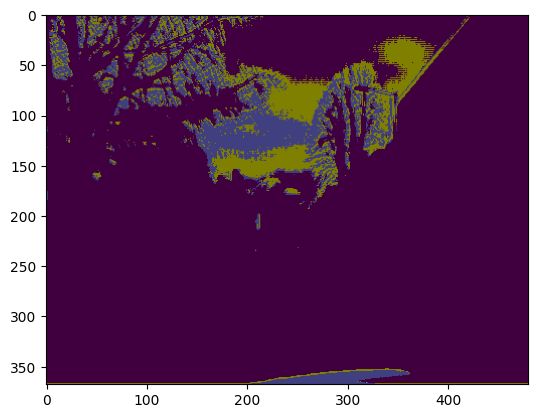

In [73]:
#---------------------Plot de imagens----------------------
plt.imshow(colors[pred_softmax].cpu())
#plt.imshow(test_data[0][0].permute(1, 2, 0).to(int))
#plt.imshow(colors[train_data[0][1].to(int)].to(int).cpu())
train_data[0][1].unique(return_counts = True)

In [74]:
#--------------------Loops de treino e teste-------------
def loop_treino(dataloader, modelo, loss_fc, otimizador, scheduler, epochs=20):
    modelo.to(device)
    for epoch in range(epochs):
        modelo.train()

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)

            pred = modelo(X)
            loss = loss_fc(pred, y.to(int))

            otimizador.zero_grad()
            loss.backward()
            otimizador.step()

            running_loss += loss.item() * X.size(0)

            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == y).sum().item()
            total_samples += torch.numel(y)

            progress_bar.set_postfix(loss=loss.item())

        scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct_predictions / total_samples

        print(f"Fim Epoch {epoch+1}:")
        print(f"   -> Loss: {epoch_loss:.4f}")
        print(f"   -> Acc: {epoch_acc:.4f}")
        print(f"   -> LR: {scheduler.get_last_lr()[0]:.6f}\n")


def loop_teste(dataloader, modelo, loss_fc):
    modelo.eval()

    tamanho = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = modelo(X)
            loss_test += loss_fc(pred, y).item()
            acertos += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss_test /= num_batches
    print(f"Erro no Teste: \n Perda média: {loss_test:>8f} \n")

In [77]:
#--------------Data loader, erro, otimizador, etc----------------------
batch_size = 14
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

weights = classes["frequencies"].sum()/(classes["frequencies"] + 1e0)
error = nn.CrossEntropyLoss()#weight = torch.Tensor(weights).to(device))


In [78]:
loop_treino(train_dataloader, model, error, optimizer, scheduler)

Epoch 1: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it, loss=1.78]


Fim Epoch 1:
   -> Loss: 2.5289
   -> Acc: 0.4264
   -> LR: 0.001000



Epoch 2: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it, loss=1.3]


Fim Epoch 2:
   -> Loss: 1.6520
   -> Acc: 0.5259
   -> LR: 0.001000



Epoch 3: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it, loss=1.41]


Fim Epoch 3:
   -> Loss: 2.0839
   -> Acc: 0.4826
   -> LR: 0.001000



Epoch 4: 100%|██████████| 27/27 [01:04<00:00,  2.37s/it, loss=2.46]


Fim Epoch 4:
   -> Loss: 2.6777
   -> Acc: 0.4467
   -> LR: 0.001000



Epoch 5: 100%|██████████| 27/27 [01:03<00:00,  2.37s/it, loss=1.67]


Fim Epoch 5:
   -> Loss: 2.9518
   -> Acc: 0.5104
   -> LR: 0.001000



Epoch 6: 100%|██████████| 27/27 [01:03<00:00,  2.37s/it, loss=1.8]


Fim Epoch 6:
   -> Loss: 1.6286
   -> Acc: 0.5401
   -> LR: 0.001000



Epoch 7: 100%|██████████| 27/27 [01:03<00:00,  2.36s/it, loss=1.48]


Fim Epoch 7:
   -> Loss: 1.5473
   -> Acc: 0.5532
   -> LR: 0.001000



Epoch 8: 100%|██████████| 27/27 [01:03<00:00,  2.35s/it, loss=1.38]


Fim Epoch 8:
   -> Loss: 1.5049
   -> Acc: 0.5605
   -> LR: 0.001000



Epoch 9: 100%|██████████| 27/27 [01:03<00:00,  2.35s/it, loss=1.36]


Fim Epoch 9:
   -> Loss: 1.3843
   -> Acc: 0.5881
   -> LR: 0.001000



Epoch 10: 100%|██████████| 27/27 [01:03<00:00,  2.36s/it, loss=1.26]


Fim Epoch 10:
   -> Loss: 1.4028
   -> Acc: 0.5816
   -> LR: 0.000100



Epoch 11: 100%|██████████| 27/27 [01:03<00:00,  2.36s/it, loss=1.51]


Fim Epoch 11:
   -> Loss: 1.3505
   -> Acc: 0.5924
   -> LR: 0.000100



Epoch 12: 100%|██████████| 27/27 [01:04<00:00,  2.37s/it, loss=1.39]


Fim Epoch 12:
   -> Loss: 1.3142
   -> Acc: 0.6037
   -> LR: 0.000100



Epoch 13: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it, loss=1.04]


Fim Epoch 13:
   -> Loss: 1.2702
   -> Acc: 0.6182
   -> LR: 0.000100



Epoch 14: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it, loss=1.2]


Fim Epoch 14:
   -> Loss: 1.2165
   -> Acc: 0.6307
   -> LR: 0.000100



Epoch 15: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it, loss=1.13]


Fim Epoch 15:
   -> Loss: 1.1663
   -> Acc: 0.6398
   -> LR: 0.000100



Epoch 16: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it, loss=1.04]


Fim Epoch 16:
   -> Loss: 1.1428
   -> Acc: 0.6427
   -> LR: 0.000100



Epoch 17: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it, loss=0.963]


Fim Epoch 17:
   -> Loss: 1.0980
   -> Acc: 0.6626
   -> LR: 0.000100



Epoch 18: 100%|██████████| 27/27 [01:04<00:00,  2.40s/it, loss=1.07]


Fim Epoch 18:
   -> Loss: 1.0659
   -> Acc: 0.6756
   -> LR: 0.000100



Epoch 19: 100%|██████████| 27/27 [01:04<00:00,  2.38s/it, loss=0.928]


Fim Epoch 19:
   -> Loss: 1.0431
   -> Acc: 0.6864
   -> LR: 0.000100



Epoch 20: 100%|██████████| 27/27 [01:05<00:00,  2.43s/it, loss=1.2]

Fim Epoch 20:
   -> Loss: 1.0218
   -> Acc: 0.6971
   -> LR: 0.000010



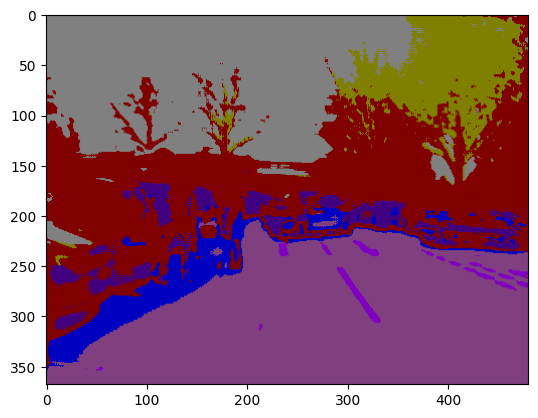

In [97]:
pred = model(test_data[11][0])
pred_softmax = pred.argmax(axis = 0)
plt.imshow(colors[pred_softmax].cpu())

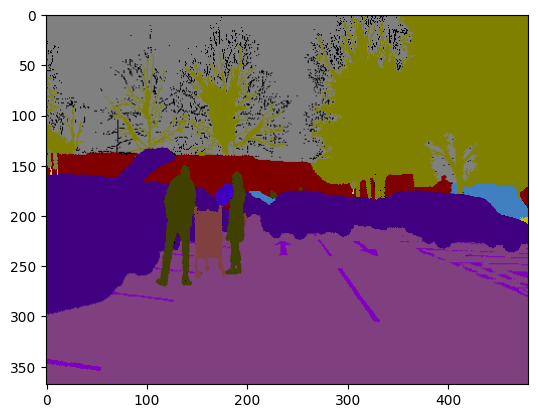

In [98]:
plt.imshow(colors[test_data[11][1].to(int)].to(int).cpu())